In [4]:
import os
import glob
import numpy as np
import pandas as pd
import cv2

from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

BASE_DIR = os.path.abspath("../..")
PROC_DIR = os.path.join(BASE_DIR, "processed")
CLASSES = ["NORMAL", "PNEUMONIA"]

In [5]:
def load_split(split):
    X, y = [], []
    for idx, cls in enumerate(CLASSES):
        pattern = os.path.join(PROC_DIR, split, cls, "*.png")
        for fp in glob.glob(pattern):
            img = cv2.imread(fp, cv2.IMREAD_GRAYSCALE)
            arr = img.ravel()
            X.append(arr)
            y.append(idx)
    return np.vstack(X), np.array(y)

X_train, y_train = load_split("train")
X_val,   y_val   = load_split("val")
X_test,  y_test  = load_split("test")

print("Shapes :", X_train.shape, y_train.shape, X_val.shape, y_val.shape)


Shapes : (5216, 50176) (5216,) (16, 50176) (16,)


In [6]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),  # 95% de la variance
    ('classifier', LogisticRegression(max_iter=1000))
])

pipeline.fit(X_train, y_train)

val_score = pipeline.score(X_val, y_val)
val_pred_proba = pipeline.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, val_pred_proba)

print(f"Score de validation: {val_score:.3f}")
print(f"AUC ROC de validation: {val_auc:.3f}")

Score de validation: 0.812
AUC ROC de validation: 1.000


Scores de validation croisée:
Moyenne : 0.954 (±0.008)


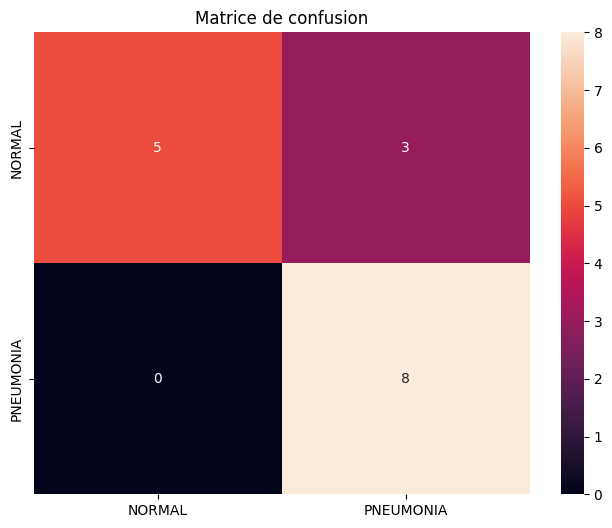


Rapport de classification:
              precision    recall  f1-score   support

      NORMAL       1.00      0.62      0.77         8
   PNEUMONIA       0.73      1.00      0.84         8

    accuracy                           0.81        16
   macro avg       0.86      0.81      0.81        16
weighted avg       0.86      0.81      0.81        16



In [7]:
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)
print("Scores de validation croisée:")
print(f"Moyenne : {cv_scores.mean():.3f} (±{cv_scores.std()*2:.3f})")

y_pred = pipeline.predict(X_val)

plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(y_val, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', 
            xticklabels=CLASSES, 
            yticklabels=CLASSES)
plt.title('Matrice de confusion')
plt.show()

print("\nRapport de classification:")
print(classification_report(y_val, y_pred, target_names=CLASSES))


Test du modèle: Logistic Regression

Test du modèle: Random Forest


/Users/hmh/Documents/IA/zoidberg/T-DEV-810-NCY_1/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hmh/Documents/IA/zoidberg/T-DEV-810-NCY_1/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hmh/Documents/IA/zoidberg/T-DEV-810-NCY_1/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 


Test du modèle: Gradient Boosting

Test du modèle: SVM

Comparaison des modèles :
                Modèle        Score CV Accuracy Val F1 NORMAL F1 PNEUMONIA  \
0  Logistic Regression  0.954 (±0.010)        0.812     0.769        0.842   
1        Random Forest  0.820 (±0.020)        0.500     0.000        0.667   
2    Gradient Boosting  0.943 (±0.014)        0.750     0.667        0.800   
3                  SVM  0.969 (±0.008)        0.750     0.667        0.800   

  Temps (s)  
0    1824.7  
1     549.9  
2     819.5  
3     695.5  


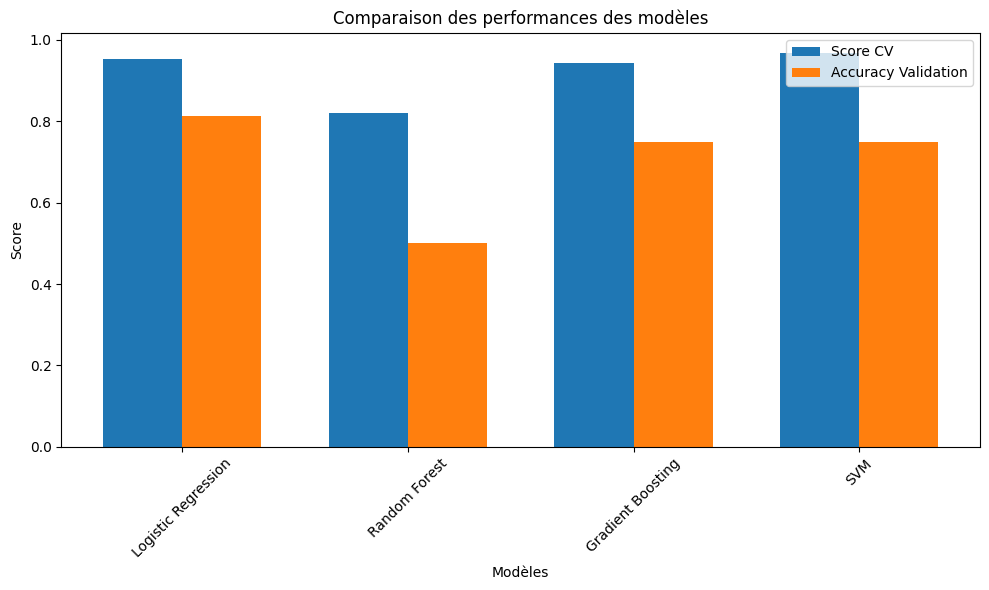

In [8]:
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100),
    'SVM': SVC(probability=True, class_weight='balanced')
}

results = []

for name, clf in classifiers.items():
    print(f"\nTest du modèle: {name}")
    
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95)),
        ('classifier', clf)
    ])
    
    start_time = time()
    scores = cross_val_score(pipe, X_train, y_train, cv=5)
    training_time = time() - start_time
    
    pipe.fit(X_train, y_train)
    
    y_val_pred = pipe.predict(X_val)
    val_accuracy = pipe.score(X_val, y_val)
    
    report = classification_report(y_val, y_val_pred, target_names=CLASSES, output_dict=True)
    
    results.append({
        'Modèle': name,
        'Score CV': f"{scores.mean():.3f} (±{scores.std()*2:.3f})",
        'Accuracy Val': f"{val_accuracy:.3f}",
        'F1 NORMAL': f"{report['NORMAL']['f1-score']:.3f}",
        'F1 PNEUMONIA': f"{report['PNEUMONIA']['f1-score']:.3f}",
        'Temps (s)': f"{training_time:.1f}"
    })

results_df = pd.DataFrame(results)
print("\nComparaison des modèles :")
print(results_df)

plt.figure(figsize=(10, 6))
models = results_df['Modèle']
cv_scores = [float(score.split()[0]) for score in results_df['Score CV']]
val_scores = [float(score) for score in results_df['Accuracy Val']]

bar_width = 0.35
x = np.arange(len(models))

plt.bar(x - bar_width/2, cv_scores, bar_width, label='Score CV')
plt.bar(x + bar_width/2, val_scores, bar_width, label='Accuracy Validation')
plt.xlabel('Modèles')
plt.ylabel('Score')
plt.title('Comparaison des performances des modèles')
plt.xticks(x, models, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
best_model_name = results_df.sort_values(by='Score CV', ascending=False).iloc[0]['Modèle']
print(f"Meilleur modèle classique: {best_model_name}")

import joblib
import os

os.makedirs("../models", exist_ok=True)

best_classifier = None
if best_model_name == 'SVM':
    best_classifier = SVC(probability=True, class_weight='balanced')
elif best_model_name == 'Gradient Boosting':
    best_classifier = GradientBoostingClassifier(n_estimators=100)

best_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('classifier', best_classifier)
])

best_pipeline.fit(X_train, y_train)
joblib.dump(best_pipeline, "../models/best_classical_model.pkl")

Meilleur modèle classique: SVM


['../models/best_classical_model.pkl']